# BTC price prediction

In [1]:
# Importing required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, cross_validate
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

In [2]:
# Placeholder for Bitcoin data (synthetic or actual data)
# Using synthetic data for demonstration
np.random.seed(42)
dates = pd.date_range(start='2016-01-01', end='2024-01-01', freq='D')
prices = np.cumsum(np.random.randn(len(dates))) + 20000  # Synthetic cumulative price data
btc_data = pd.DataFrame({'Date': dates, 'Price': prices})

In [3]:
np.random.seed(42)

# Feature engineering: Creating day, month, and year as features
btc_data['Day'] = btc_data['Date'].dt.day
btc_data['Month'] = btc_data['Date'].dt.month
btc_data['Year'] = btc_data['Date'].dt.year

# Defining features and target variable
X = btc_data[['Day', 'Month', 'Year']]
y = btc_data['Price']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# Defining models to evaluate
models = {
    'Linear Regression': LinearRegression(),
    'KNN': KNeighborsRegressor(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42, use_label_encoder=False, eval_metric='rmse'),
    'CatBoost': CatBoostRegressor(verbose=0, random_state=42)
}

# Cross Validation

#### test_score: 
* neg_mean_squared_error: The mean test score from cross-validation, specifically the negative mean squared error (MSE). A more negative value indicates a higher error, while a closer-to-zero value indicates a better fit.

In [6]:
results = {}
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores.iloc[i], std_scores.iloc[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

## function inspired by CPSC_320, UBC

In [7]:
initial_cv_results = {}
for model_name, model in models.items():
    initial_cv_results[model_name] = mean_std_cross_val_scores(model, X, y, cv=5, scoring='neg_mean_squared_error', return_train_score=True)

In [8]:
pd.DataFrame(initial_cv_results).T

,fit_time,score_time,test_score,train_score
Linear Regression,0.005 (+/- 0.003),0.002 (+/- 0.001),-304.855 (+/- 184.973),-154.449 (+/- 27.643)
KNN,0.003 (+/- 0.001),0.004 (+/- 0.001),-263.333 (+/- 145.705),-25.762 (+/- 5.507)
Random Forest,0.440 (+/- 0.039),0.011 (+/- 0.001),-192.783 (+/- 162.436),-0.109 (+/- 0.002)
XGBoost,0.125 (+/- 0.008),0.003 (+/- 0.000),-195.474 (+/- 143.235),-0.327 (+/- 0.022)
CatBoost,0.615 (+/- 0.042),0.002 (+/- 0.001),-238.233 (+/- 164.107),-1.144 (+/- 0.077)


* Most of the models are overfitting 
* RandomForest shows the most promise.

# Hyperparameter Tunning

In [9]:
rf_params = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20], 'min_samples_split': [2, 5, 10]}
rf_grid_search = GridSearchCV(RandomForestRegressor(random_state=42), rf_params, cv=5, scoring='neg_mean_squared_error')
rf_grid_search.fit(X_train, y_train)  # Uncomment to fit

# XGBoost hyperparameter tuning
xgb_params = {'n_estimators': [50, 100, 200], 'max_depth': [3, 5, 7], 'learning_rate': [0.01, 0.1, 0.3], 'subsample': [0.8, 1.0]}
xgb_grid_search = GridSearchCV(XGBRegressor(random_state=42, use_label_encoder=False), xgb_params, cv=5, scoring='neg_mean_squared_error')
xgb_grid_search.fit(X_train, y_train)

# CatBoost hyperparameter tuning
cat_params = {'iterations': [100, 200, 500], 'learning_rate': [0.01, 0.1, 0.3], 'depth': [3, 5, 7]}
cat_random_search = RandomizedSearchCV(CatBoostRegressor(verbose=0, random_state=42), cat_params, cv=5, n_iter=10, scoring='neg_mean_squared_error', random_state=42)
cat_random_search.fit(X_train, y_train)


RandomizedSearchCV(cv=5,
                   estimator=<catboost.core.CatBoostRegressor object at 0x111d9c130>,
                   param_distributions={'depth': [3, 5, 7],
                                        'iterations': [100, 200, 500],
                                        'learning_rate': [0.01, 0.1, 0.3]},
                   random_state=42, scoring='neg_mean_squared_error')

In [10]:
# Cross-validation after hyperparameter tuning (replace the tuned models accordingly)
tuned_models = {
    'Tuned Random Forest': rf_grid_search.best_estimator_ if 'rf_grid_search' in locals() else RandomForestRegressor(random_state=42),
    'Tuned XGBoost': xgb_grid_search.best_estimator_ if 'xgb_grid_search' in locals() else XGBRegressor(random_state=42, use_label_encoder=False, eval_metric='rmse'),
    'Tuned CatBoost': cat_random_search.best_estimator_ if 'cat_random_search' in locals() else CatBoostRegressor(verbose=0, random_state=42)
}

In [11]:
tuned_cv_results = {}
for model_name, model in tuned_models.items():
    tuned_cv_results[model_name] = mean_std_cross_val_scores(model, X, y, cv=5, scoring='neg_mean_squared_error')

In [12]:
pd.DataFrame(tuned_cv_results).T

,fit_time,score_time,test_score
Tuned Random Forest,1.034 (+/- 0.229),0.042 (+/- 0.034),-192.629 (+/- 162.379)
Tuned XGBoost,0.521 (+/- 0.164),0.004 (+/- 0.001),-190.861 (+/- 146.037)
Tuned CatBoost,0.290 (+/- 0.020),0.003 (+/- 0.001),-177.520 (+/- 124.487)


# Next Steps:
* Given that our test scores are still very low even after hyperparameter tunning, we will treat the problem as a time-series problem and try to solve it as such.

/Users/nima/miniconda3/envs/cpsc330/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/nima/miniconda3/envs/cpsc330/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


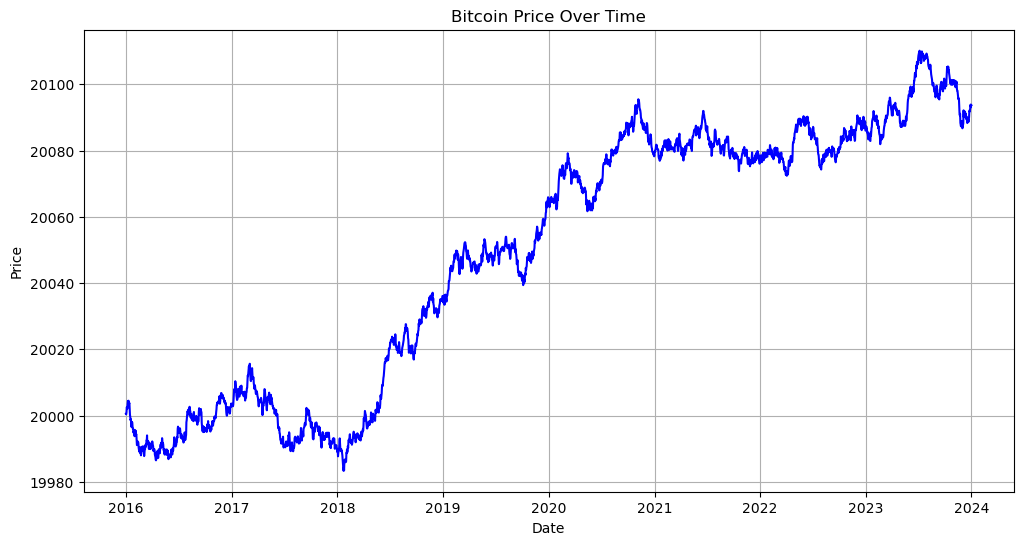

/Users/nima/miniconda3/envs/cpsc330/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


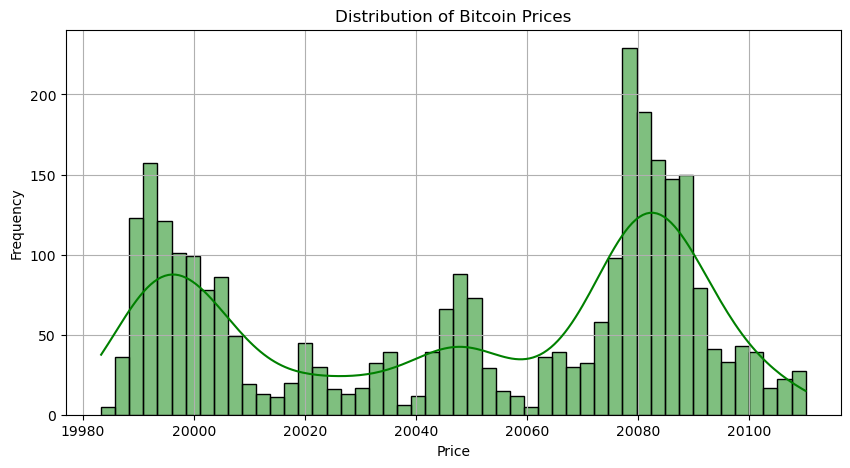

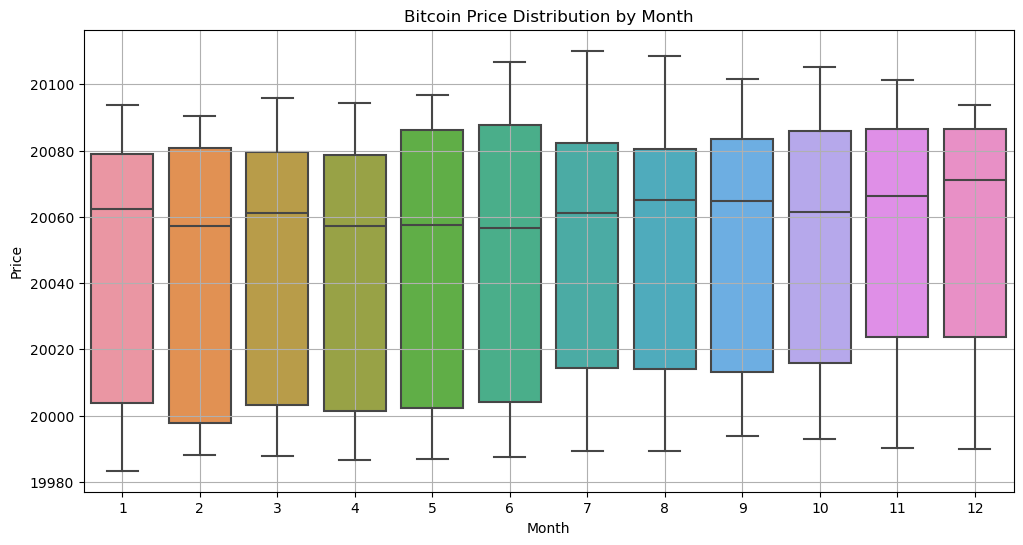

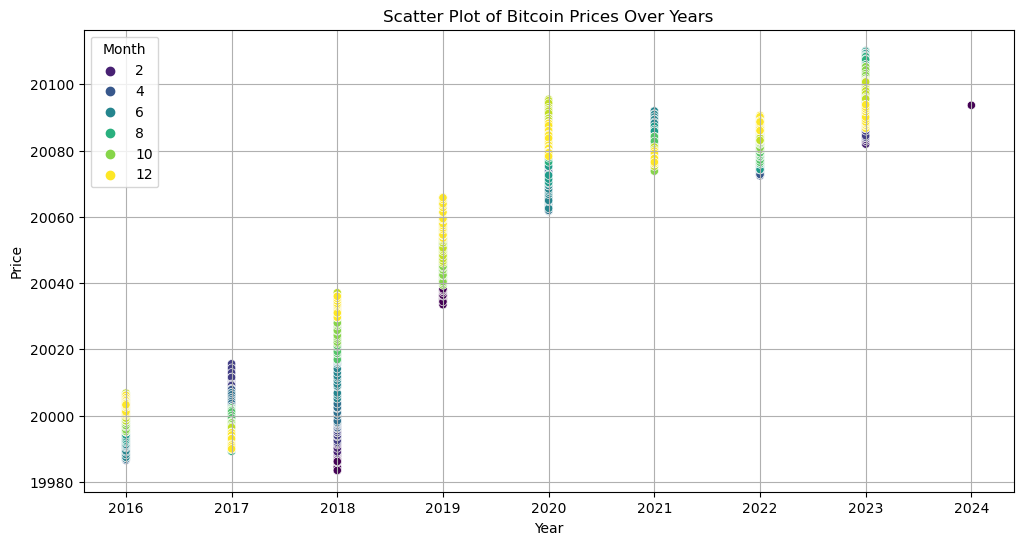

In [13]:
# Importing necessary visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Combine features and target into a single DataFrame for visualization
data = pd.DataFrame({'Day': X['Day'], 'Month': X['Month'], 'Year': X['Year'], 'Price': y})

# Convert date columns back to a datetime format for plotting
data['Date'] = pd.to_datetime(data[['Year', 'Month', 'Day']])

# Plotting the entire price trend over time
plt.figure(figsize=(12, 6))
sns.lineplot(x='Date', y='Price', data=data, color='blue')
plt.title('Bitcoin Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.show()

# Plotting the distribution of Bitcoin prices
plt.figure(figsize=(10, 5))
sns.histplot(data['Price'], bins=50, kde=True, color='green')
plt.title('Distribution of Bitcoin Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Boxplot to visualize price distribution across different months
plt.figure(figsize=(12, 6))
sns.boxplot(x='Month', y='Price', data=data)
plt.title('Bitcoin Price Distribution by Month')
plt.xlabel('Month')
plt.ylabel('Price')
plt.grid(True)
plt.show()

# Scatter plot to check for seasonality or trend over the years
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Year', y='Price', data=data, hue='Month', palette='viridis')
plt.title('Scatter Plot of Bitcoin Prices Over Years')
plt.xlabel('Year')
plt.ylabel('Price')
plt.legend(title='Month')
plt.grid(True)
plt.show()


In [14]:
# Import necessary libraries
import pandas as pd

# Create a copy of the original data for lagged feature creation
lagged_data = data.copy()

# Create lagged features (e.g., price at previous 1 day, 2 days, etc.)
lagged_data['Price_lag1'] = lagged_data['Price'].shift(1)  # Price 1 day ago
lagged_data['Price_lag2'] = lagged_data['Price'].shift(2)  # Price 2 days ago
lagged_data['Price_lag3'] = lagged_data['Price'].shift(3)  # Price 3 days ago
lagged_data['Price_lag4'] = lagged_data['Price'].shift(4)  # Price 4 days ago
lagged_data['Price_lag5'] = lagged_data['Price'].shift(5)  # Price 3 days ago



# You can add more lagged features as needed, based on how far back you want to look.
# For example, lagging up to 7 days or even 30 days if there's enough data.

# Create rolling window features
lagged_data['Price_rolling_mean7'] = lagged_data['Price'].rolling(window=7).mean()  # 7-day rolling mean
lagged_data['Price_rolling_std7'] = lagged_data['Price'].rolling(window=7).std()    # 7-day rolling standard deviation

# Drop any rows with missing values that resulted from shifting (or you can choose to impute them)
lagged_data.dropna(inplace=True)

# Separate features and target variable
X_lagged = lagged_data.drop(['Price', 'Date'], axis=1)  # Exclude original price and date for feature set
y_lagged = lagged_data['Price']

# Print a sample of the new data
print(lagged_data.head())

# At this point, you can proceed with training models on the new lagged feature set.


    Day  Month  Year         Price       Date    Price_lag1    Price_lag2  \
6     7      1  2016  20003.640091 2016-01-07  20002.060878  20002.295015   
7     8      1  2016  20004.407525 2016-01-08  20003.640091  20002.060878   
8     9      1  2016  20003.938051 2016-01-09  20004.407525  20003.640091   
9    10      1  2016  20004.480611 2016-01-10  20003.938051  20004.407525   
10   11      1  2016  20004.017193 2016-01-11  20004.480611  20003.938051   

      Price_lag3    Price_lag4    Price_lag5  Price_rolling_mean7  \
6   20002.529168  20001.006138  20000.358450         20001.769493   
7   20002.295015  20002.529168  20001.006138         20002.328181   
8   20002.060878  20002.295015  20002.529168         20002.839552   
9   20003.640091  20002.060878  20002.295015         20003.335906   
10  20004.407525  20003.640091  20002.060878         20003.548481   

    Price_rolling_std7  
6             1.199378  
7             1.401509  
8             1.201853  
9             1.022562

Epoch 1/50


/Users/nima/miniconda3/envs/cpsc330/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.0864 - val_loss: 4.8697e-04
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0042 - val_loss: 0.0023
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0037 - val_loss: 0.0014
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0036 - val_loss: 7.3005e-04
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0032 - val_loss: 4.6521e-04
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0030 - val_loss: 0.0011
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0028 - val_loss: 7.1036e-04
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0027 - val_loss: 7.7399e-04
Epoch 9/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0026 - val_loss: 5.7850e-04
Epoch 10/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0024 - val_loss: 0.0013
Epoch 11/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0026 - val_loss: 0.0011
Epoch 12/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 

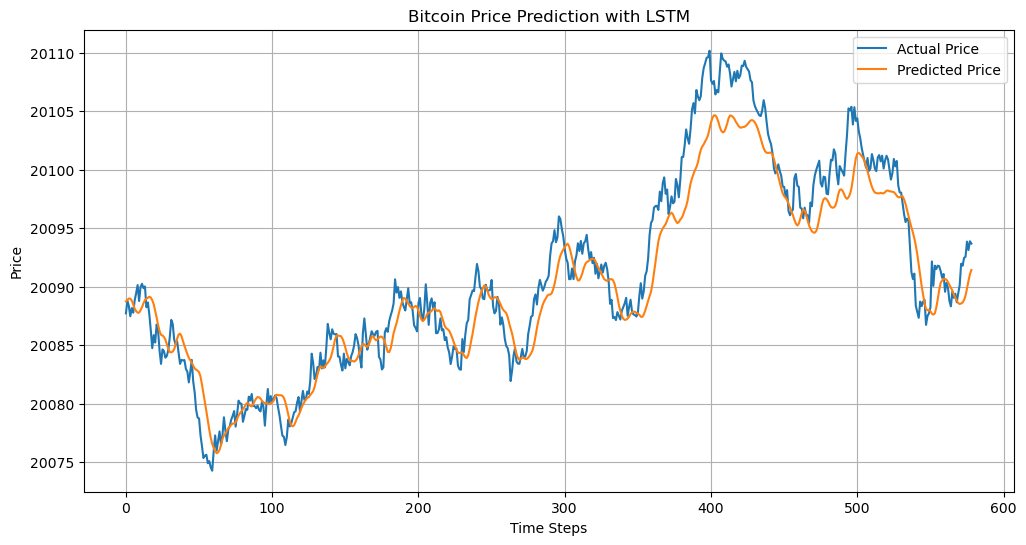

In [17]:
# Import necessary libraries for LSTM
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Prepare the data for LSTM
# Using the lagged_data generated previously
scaler = MinMaxScaler()

# Fit the scaler only on the training data and transform both train and test sets
train_size = int(len(lagged_data) * 0.8)  # 80% for training, 20% for testing
train_data = lagged_data[:train_size]
test_data = lagged_data[train_size:]

# Scale only the training data
train_scaled = scaler.fit_transform(train_data[['Price', 'Price_lag1', 'Price_lag2', 'Price_lag3', 'Price_rolling_mean7', 'Price_rolling_std7']])
test_scaled = scaler.transform(test_data[['Price', 'Price_lag1', 'Price_lag2', 'Price_lag3', 'Price_rolling_mean7', 'Price_rolling_std7']])

# Create sequences for LSTM input (e.g., using the last 5 time steps to predict the next)
def create_sequences(data, n_steps=5):
    X, y = [], []
    for i in range(n_steps, len(data)):
        X.append(data[i-n_steps:i, 1:])  # Use lagged features as predictors
        y.append(data[i, 0])  # Use original price as target
    return np.array(X), np.array(y)

# Generate sequences
n_steps = 5
X_train, y_train = create_sequences(train_scaled, n_steps)
X_test, y_test = create_sequences(test_scaled, n_steps)

# Reshape input to be [samples, time steps, features] for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(n_steps, X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))  # Final layer with a single output (price)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Predict on the test data
y_pred = model.predict(X_test)

# Inverse transform predictions and actual values to original scale
y_pred_inv = scaler.inverse_transform(np.concatenate([y_pred, np.zeros((len(y_pred), X_test.shape[2]))], axis=1))[:, 0]
y_test_inv = scaler.inverse_transform(np.concatenate([y_test.reshape(-1, 1), np.zeros((len(y_test), X_test.shape[2]))], axis=1))[:, 0]

# Visualize the predictions against actual values
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Actual Price')
plt.plot(y_pred_inv, label='Predicted Price')
plt.title('Bitcoin Price Prediction with LSTM')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


#### Observations:
* The model seems to be accurately predicting the price.

Mean Squared Error (MSE): 6.53
Mean Absolute Error (MAE): 1.96
R² Score: 0.91


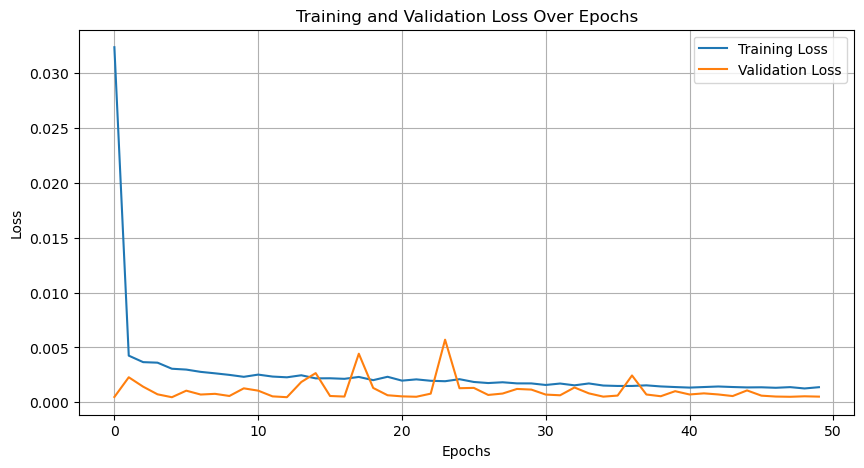

In [18]:
# Assuming the previous LSTM code has been executed, we'll re-import the necessary libraries.
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Calculate evaluation metrics
mse = mean_squared_error(y_test_inv, y_pred_inv)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

# Print the evaluation metrics
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R² Score: {r2:.2f}")

# Plot training and validation loss curves to confirm model performance
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


* A relatively low MSE and MAE show that the error between actual and predicted prices is minimal.
* The R² score of 0.91 indicates that 91% of the variance in the Bitcoin price is explained by the model, which is a strong indication of good fit.

In [19]:
model.predict("2023-12-30")

ValueError: Unrecognized data type: x=2023-12-30 (of type <class 'str'>)